The first step of any analysis in neuroscience is took look at your raw data. This is important for all kinds of reasons - most notably masking sure that you haven't made a mistake in labeling channels, timepoints, etc.

## Background reading
The ecog signal is really interesting, quite complicated, and poorly understood. It's best to have a background in signal processing, though if you don't then try to learn this as you do your first analyses...there are quite a few "gotchas" if you don't know what you're doing in time-domain signals.

That said, here we'll focus on some general analysis techniques as well as the ecog signal specifically. There's a lot of attention paid to high-gamma activity in ecog. Here are a few papers that discuss where it comes from what what it means.

* [Nathan Crone's review paper](http://www.ncbi.nlm.nih.gov/pubmed/21081143) on high gamma activity and our understanding of it is a good place to start.
* [Kai Miller's paper on broadband high-gamma](http://www.jneurosci.org/content/29/10/3132.full) suggests that high-gamma activity isn't really an "oscillatory" signal, and isn't restricted to >70Hz regions of the power spectrum. Instead, it's a broadband signal that reflects as a global power increase across all frequencies.
* [Supratim Ray's paper](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000610) on the cellular origin of high-gamma covers what kinds of neurophysiology might create this signal. 

## Now on to the data
First we'll just look at some raw data. We've collected a dataset where the subject was listening to spoken sentences. We have an audio file with those sentences, a brain file with their brain activity, and a list of times for when the sentences began. (actually, rather than a raw audio file we have a spectrogram of audio, but we'll get to that later).

We'll load some brain activity, and audio recorded at the same time. We'll use the package `MNE-python` for keeping track of brain/audio timeseries data.

In [1]:
import mne
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ecogtools as et
import seaborn as sns
sns.set_style('white')

# This ensures that you'll be able to use interactive plots
%matplotlib notebook

/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag(

In [2]:
# These are stored as "fif" files, which MNE reads easily
brain = mne.io.Raw('./data/ecog_clean_raw.fif', add_eeg_ref=False, preload=True)
audio = mne.io.Raw('./data/spectrogram.fif', add_eeg_ref=False, preload=True)

/Users/choldgraf/src/python/mne-python/mne/utils.py:268: UserWarning: This filename (/Users/choldgraf/gdrive/github/personal/writeups/neuro/ecog/data/spectrogram.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  '%s' % (fname, filetype, print_endings))


<IPython.core.display.Javascript object>


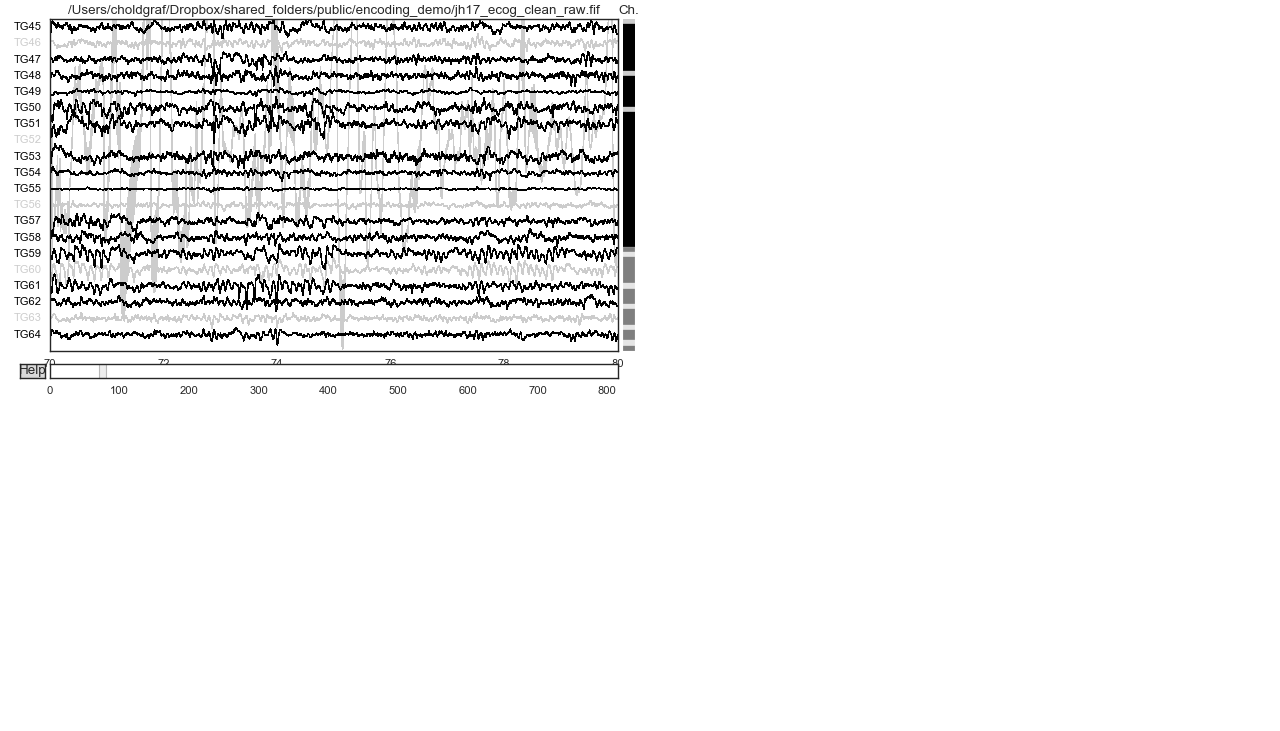

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

In [8]:
# First we'll just glance through the brain activity.
# For plot visualizations
scale = brain._data[0].max()

# This should pop out an interactive plot, scroll through the data
f = brain.plot(scalings={'eeg': scale}, show=False)
f.set_size_inches(8, 5)

OK, looks like a lot of stuff is going on. You can scroll left and right to see more times, and up/down to see more channels. This is useful for getting a general view of the data, but we care specifically about the response to sound. We'll pull out only the timepoints corresponding to audio onsets. We can do this using an `Epochs` object and the time onsets.

In [10]:
# Load our times file, which is stored as a CSV of events
mtime = pd.read_csv('./data/time_info.csv', index_col=0)

# Pull only the trials we care about
mtime = mtime.query('t_type=="mid" and t_num > 0')

# These are the start/stop times for sound
mtime.head()

,start,stop,_notes,t_type,t_num,filt_type,kind,id,noise_stim
7,44.111375,47.144813,NaN,mid,1,norm,trial,7,none
10,62.315312,64.253875,NaN,mid,2,norm,trial,10,none
13,76.878563,78.971688,NaN,mid,3,norm,trial,13,none
16,88.910438,91.821500,NaN,mid,4,norm,trial,16,none
19,106.426937,109.531188,NaN,mid,5,norm,trial,19,none


In [10]:
# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * brain.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T

# This is just a metadata dictionary.
# If we had multiple event types, we'd specify here.
einfo = dict(myevent=1)

# First columns == event start ix, last columns == event id
ev[:5]

array([[ 44111,      0,      1],
       [ 62315,      0,      1],
       [ 76878,      0,      1],
       [ 88910,      0,      1],
       [106426,      0,      1]])

Epochs objects are a way to represent data that is time-locked to events of interest. We can pull a window before/after an event, which is useful for things like baselining, averaging, and seeing a time-locked effect.

In [11]:
# First low-pass filter to remove some noise
brain_epochs = brain.copy()
brain_epochs.filter(0, 20)

# Now we'll turn the raw array into epochs shape
tmin, tmax = -.5, 2
epochs = mne.Epochs(brain_epochs, ev, einfo, tmin, tmax,
                    baseline=(None, 0), preload=True)

# shape (trials, channels, time)
print(epochs._data.shape)

(47, 64, 2501)


<IPython.core.display.Javascript object>


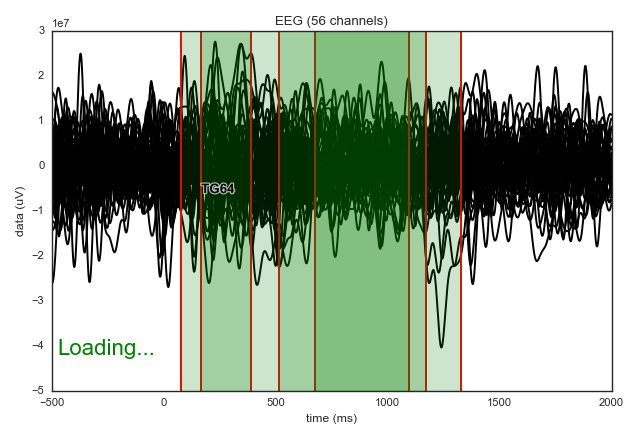

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

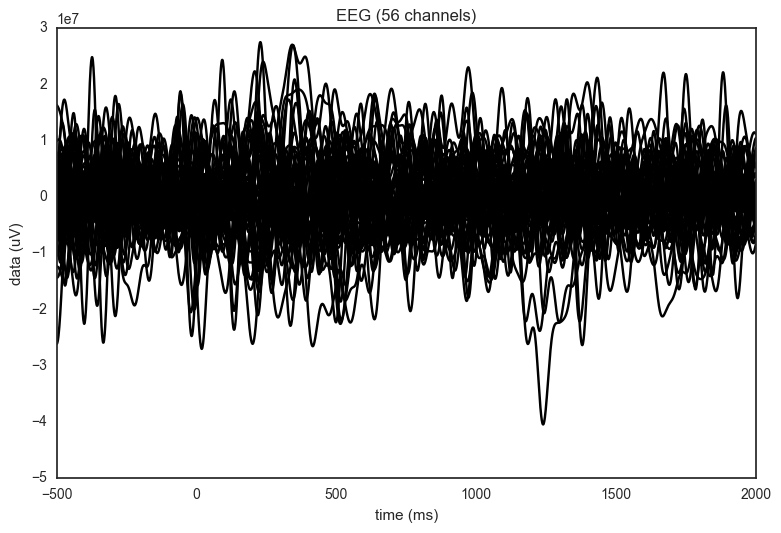

In [12]:
# Let's average across all epochs to see if any channels are responsive
epochs.average().plot()

This looks...complicated. This is because we're using the raw brain signals we recorded from the patient. These signals have all kinds of things going on in them, which is why the outputs look so noisy. To get around this, we can try to isolate specific parts of the raw signals.

In particular, "high-frequency" components of the signal have been shown to be responsive to stimuli in the world. We can reveal this information by doing a "high-pass" filter that removes all of the lower-frequency components.

In [10]:
# We'll do this on the raw data for reasons we can talk about later
brain.filter(70, 150)

Now we will take the *amplitude* of this filtered data. It tells us how large/small is the signal in general. We do this using a "Hilbert Transform", which is a mathematical trick to calculate the amplitude of an oscillatory signal (as well as it's phase but we won't worry about that here)

In [11]:
# We'll also add zeros to our data so that it's of a length 2**N.
# In signal processing, everything goes faster if your data is length 2**N :-)
next_pow2 = int(np.ceil(np.log2(brain.n_times)))
brain.apply_hilbert(range(len(brain.ch_names)), envelope=True,
                    n_fft=2**next_pow2)

# Now that we've extracted the amplitude, we'll low-pass filter it to remove noise
brain.filter(None, 20)

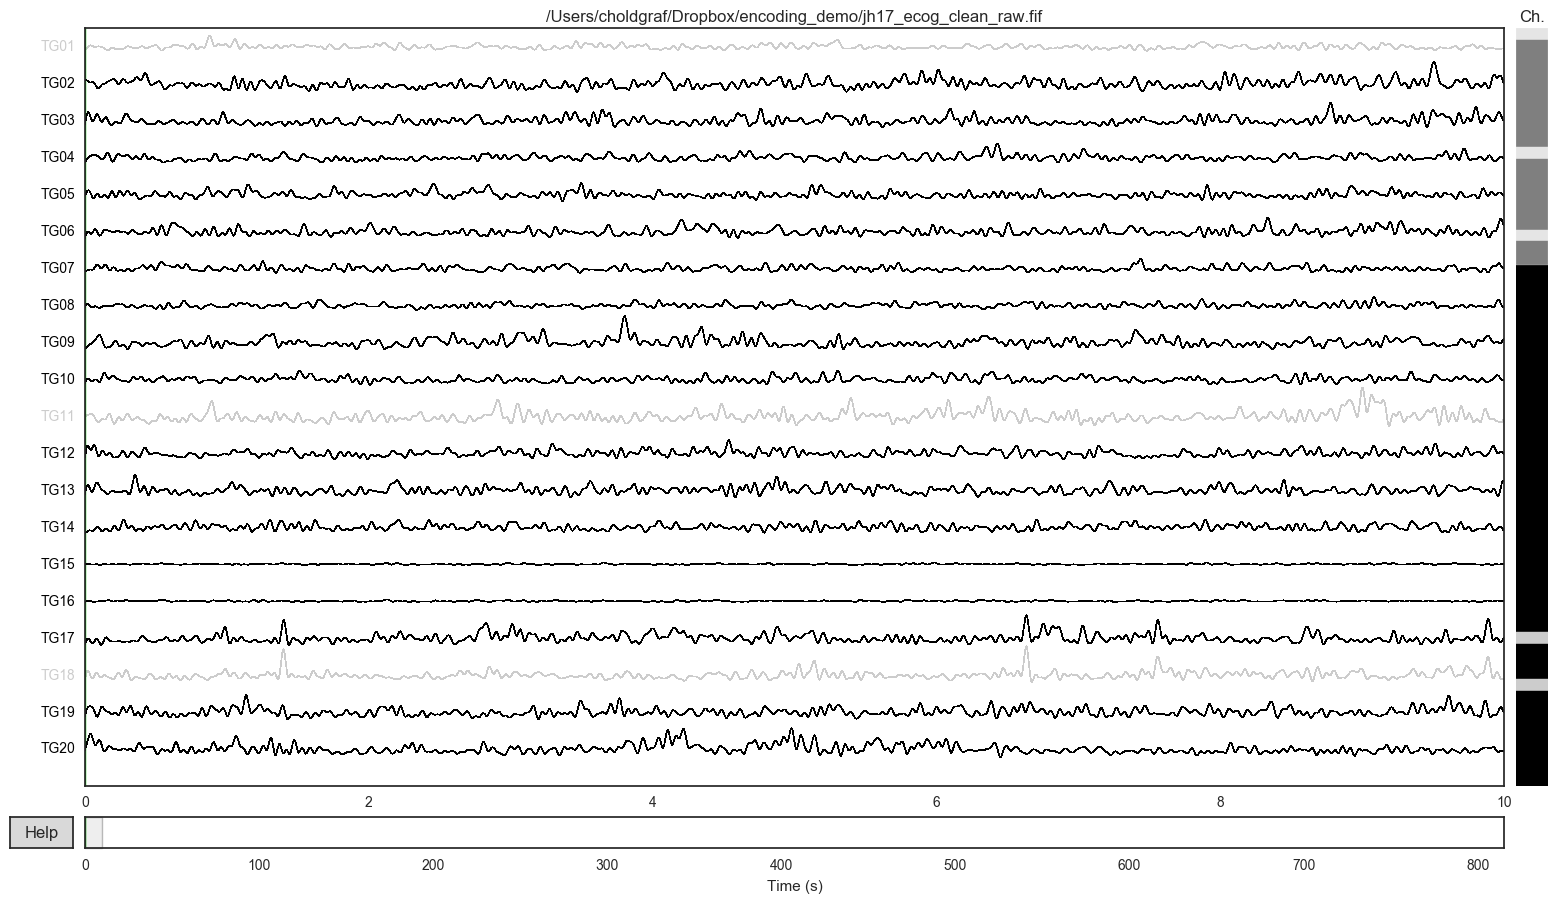

In [12]:
# Now take another look at the data
scale = brain._data[0].max()
brain.plot(scalings={'eeg': scale})

It looks quite different, and a bit cleaner. This is partially because now we've calculated **amplitude**, which goes from 0 and upward. It's never negative. This is because the amplitude of high-gamma activity is reflective of "stuff going on in general", and you can't have negative "stuff going on".

Te recap, we've:

1. Filtered out raw signal between 70 - 150Hz
2. Calculated the Hilbert Transform of this signal
3. Taken the absolute value of the transform (this returns the amplitude)
4. Low-pass filtered the output to clean it up.

We'll create epochs again and see if this changes our average plots:

In [13]:
tmin, tmax = -.5, 2
epochs = mne.Epochs(brain, ev, einfo, tmin, tmax,
                    baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(epochs._data.shape)

(47, 64, 2501)


In [14]:
# We'll rescale the epochs to show the increase over baseline using a
# "z" score. This subtracts the baseline mean, and divides by baseline
# standard deviation
_ = mne.baseline.rescale(epochs._data, epochs.times, [-.5, 0], 'zscore', copy=False)

<IPython.core.display.Javascript object>


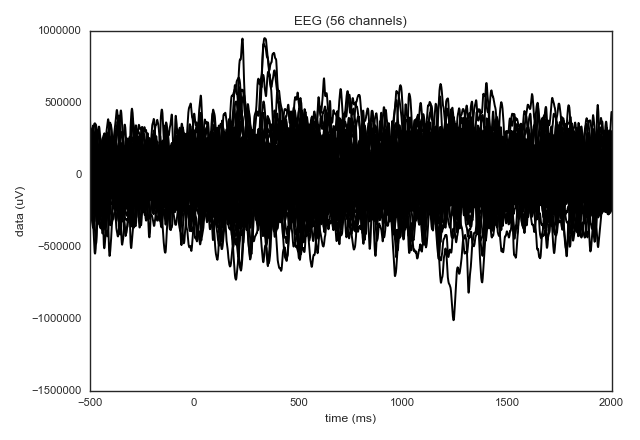

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

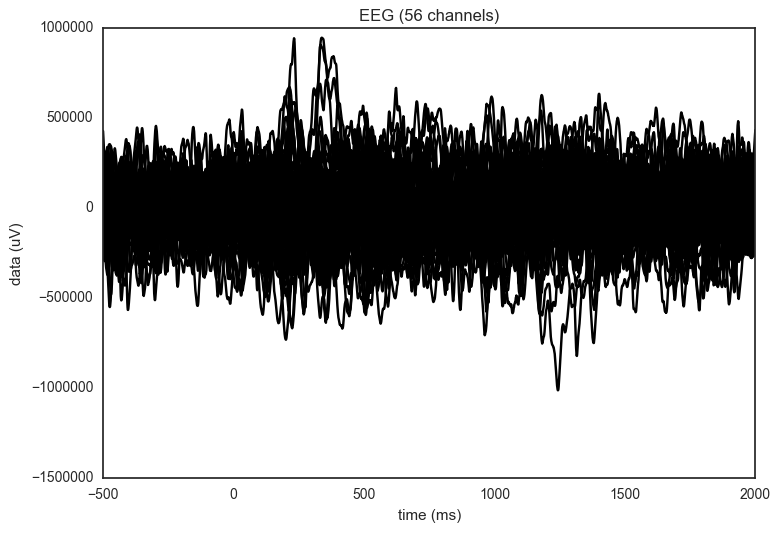

In [15]:
# Let's look at the average plots again
epochs.average().plot()

Interesting - now it seems like, while some channels are still all over the place, there are a few that have an increased amplitude above everything else. If you want to visualize each channel individually, do it like this:

<IPython.core.display.Javascript object>


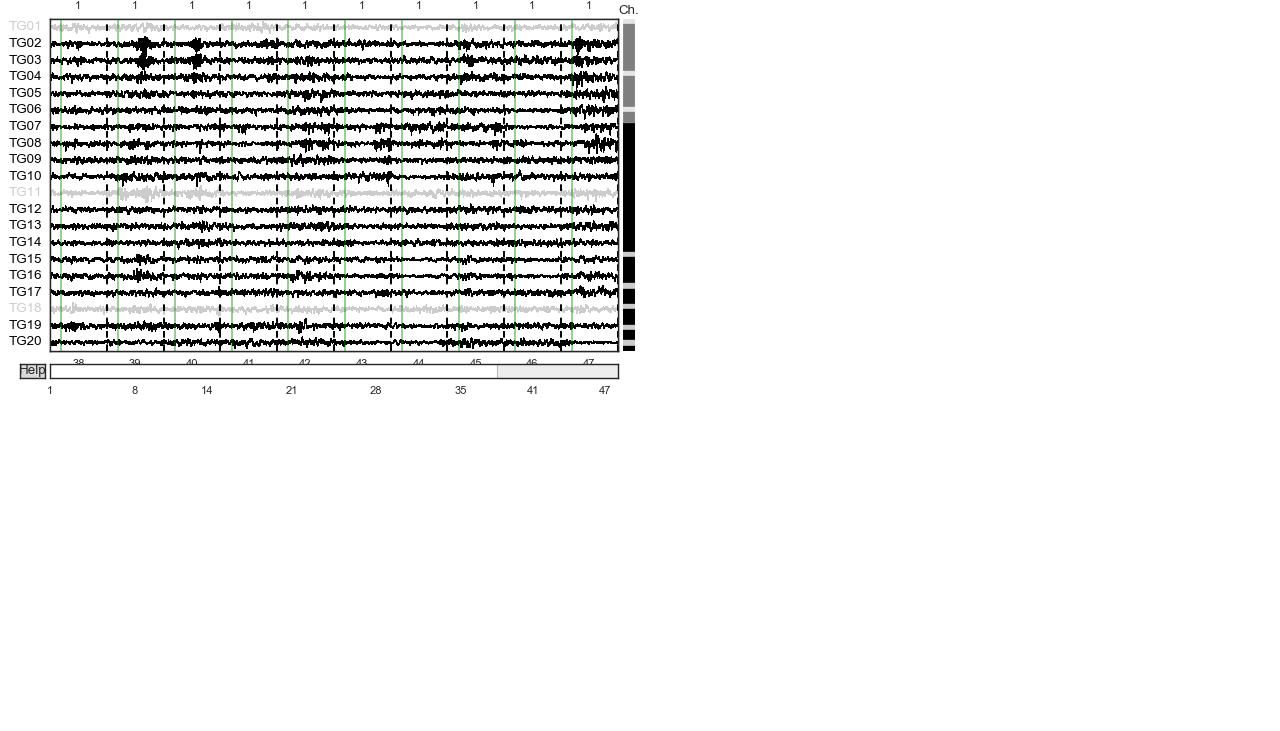

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(sel

In [17]:
# Use the arrow keys to move around.
# Green line == time 0. Dotted line == epoch start
# See if some electrodes seem to "turn on" in response to the sound.
scale = 10
f = epochs.plot(scalings=scale, n_epochs=10)
f.set_size_inches(8, 5)

Looking through the data, maybe you note some channels that are more "active" than others. AKA, ones that show a response when the sound begins (green lines are sound onsets). Let's look at one closer to see what it looks like.

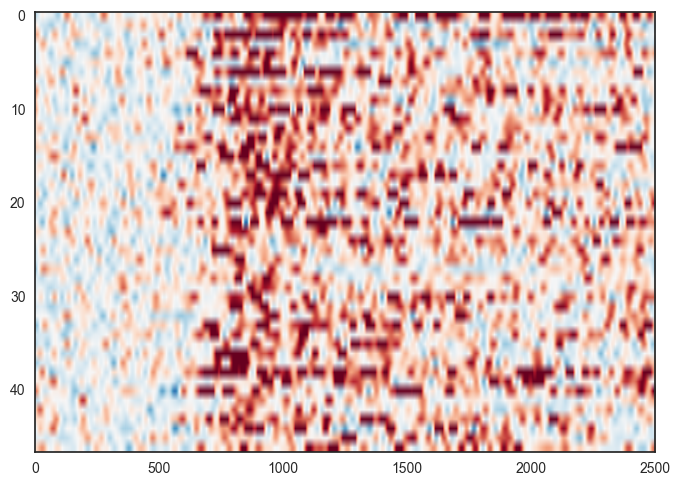

In [17]:
# Another way to look at this is with an image.
# Here are the trial activations for one electrode:
# It looks like this channel is responsive
use_chan = 'TG37'
ix_elec = mne.pick_channels(epochs.ch_names, [use_chan])[0]
plt_elec = epochs._data[:, ix_elec, :]

f, ax = plt.subplots()
ax.imshow(plt_elec, aspect='auto', cmap=plt.cm.RdBu_r, vmin=-5, vmax=5)
f

You can see a clear increase in activity near t== 0 (500 on the xaxis above). So this seems like an electrode that **does** respond to sound.

I should note, this is one of the really powerful things about electrocorticography recordings. It allows you to see a clear effect on an individual trial. Most other methods in human neuroscience require you to average across many trials before anything clear pops up.

## Sound we played

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


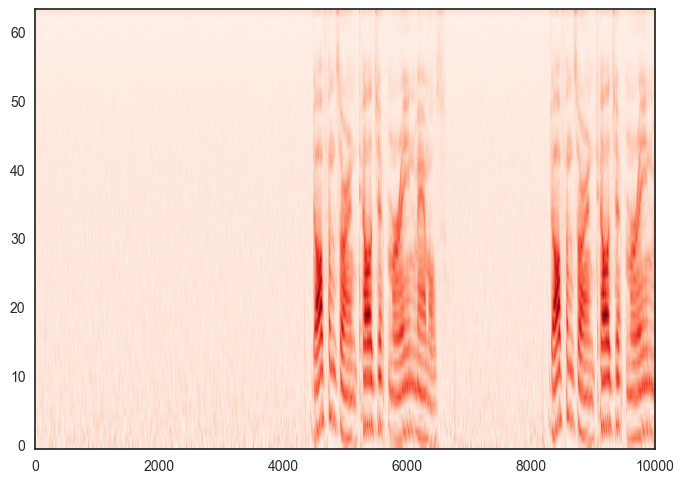

In [26]:
f, ax = plt.subplots()

# This will plot 10 seconds.
ax.imshow(audio._data[:, :10*audio.info['sfreq']],
          aspect='auto', origin='lower', cmap=plt.cm.Reds)

Those regions of "hot" colors show when the sound is present. Rows near the bottom are slow-moving parts of the sound, and rows near the top are fast-moving parts.

Maybe the presence of these spectral features can be used to predict the ecog activity. To address this question, we'll use the same regression technique. In this case, our inputs will be the spectrogram above (as X) and the output will be the high-gamma activity in the electrode (as y).

There is one extra step - we don't expect the brain to respond *immediately* to sounds in the world. That's because it takes time for the signal to get from your ears to your auditory cortex. As such, we'll include "time-lagged" versions of the above spectrogram as extra features in our model:

In [27]:
# First we'll cut up the data so that we don't overload memory
# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * audio.info['sfreq']
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T
einfo = dict(myevent=1)

# Now we'll turn the raw array into epochs shape
tmin, tmax = -.5, 2
epochs_audio = mne.Epochs(audio, ev, einfo, tmin, tmax,
                          baseline=(None, 0), preload=True)

# We'll decimate the data because we've got more datapoints than we need
epochs_audio.decimate(10)

<Epochs  |  n_events : 47 (all good), tmin : -0.5 (s), tmax : 2.0 (s), baseline : (None, 0)>

# Wrapping up
OK, so what have we learned here? We accomplished the following steps:

1. Look at raw brain data
1. Look at the raw activity in response to sound
1. Filter our brain data to extract high-gamma amplitude
1. See that high-gamma has a more reliable response to sound

That's a very, very tip-of-the-iceberg introduction to fitting encoding models in the brain, which is the flip-side to fitting "decoding" models in the brain. We'll go into more detail on that later.